# Подготовка данных для уравнений ХХ из статьи Рыбака

## Импорт библиотек и стандартные условия системы ХХ

In [70]:
import numpy as np
import warnings

from scipy.integrate import odeint
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'svg' 

def disp(Vy, T):
    # Conductions
    fig, (ax, ay) = plt.subplots(1, 2, figsize=(12, 5))
    g_k = gK * np.power(Vy[:, 1], 4.0)
    g_na = gNa*np.power(Vy[:, 2], 3.0) * Vy[:, 3]
    ax.plot(T, g_k, linestyle="--", linewidth = 0.8, label=r"$g_{K}$")
    ax.plot(T, g_na,linestyle="-", linewidth = 0.8, label=r"$g_{Na}$")
    ax1 = ax.twinx()
    ax1.plot(T, Vy[:, 0],linewidth = 0.8, color="m", label=r"$V_m$")
    ax.set_xlabel('T (ms)', size=10)
    ax.set_ylabel(r"$g_i$", size=10)
    ax1.set_ylabel(r"$V_m$, mV", size=10)
    ax.grid()
    fig.legend(loc=3)
    ax.set_title('Динамика проводимости каналов')
    ay.plot(Vy[:, 0], g_k, "-.k")
    ay.set_title(r"Фазовая зависимость $g_{Na}(V)$")
    ay.grid()
    return fig

# Дефолтные коэффиценты
# Проводимость калиевых каналов (mS/cm^2)
gK = 36.0

# Проводимость натринвых каналов (mS/cm^2)
gNa = 120.0

# Проводимость каналов прочих ионов(mS/cm^2)
gL = 0.3

# Удельная емкость мембраны (uF/cm^2)
Cm = 1.0

# Потенциал калиевого канала (mV)
VK = -77.0

# Потенциал натриевого насоса (mV)
VNa = 50.0

# Потенциал насосов других ионов (mV)
Vl = -54.4


# Дефолтные параметры
# Константы скорости движения ионов в каналах
def alpha_n(Vm):
    return (0.01*(Vm+55.0))/(1.0-np.exp((-0.1*Vm-5.5)))

def beta_n(Vm):
    return 0.125*np.exp(-(Vm+65.0)/80.0)

def alpha_m(Vm):
    return (0.1*(Vm+40.0))/(1-np.exp(-0.1*Vm-4))

def beta_m(Vm):
    return 4.0*np.exp((-Vm-65.0)/18.0)

def alpha_h(Vm):
    return 0.07*np.exp((-Vm-65.0)/20.0)

def beta_h(Vm):
    return 1.0/(1.0+np.exp(-0.1*Vm-3.5))


def n_inf(Vm):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))

def m_inf(Vm):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))

def h_inf(Vm):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))

## Основные константы
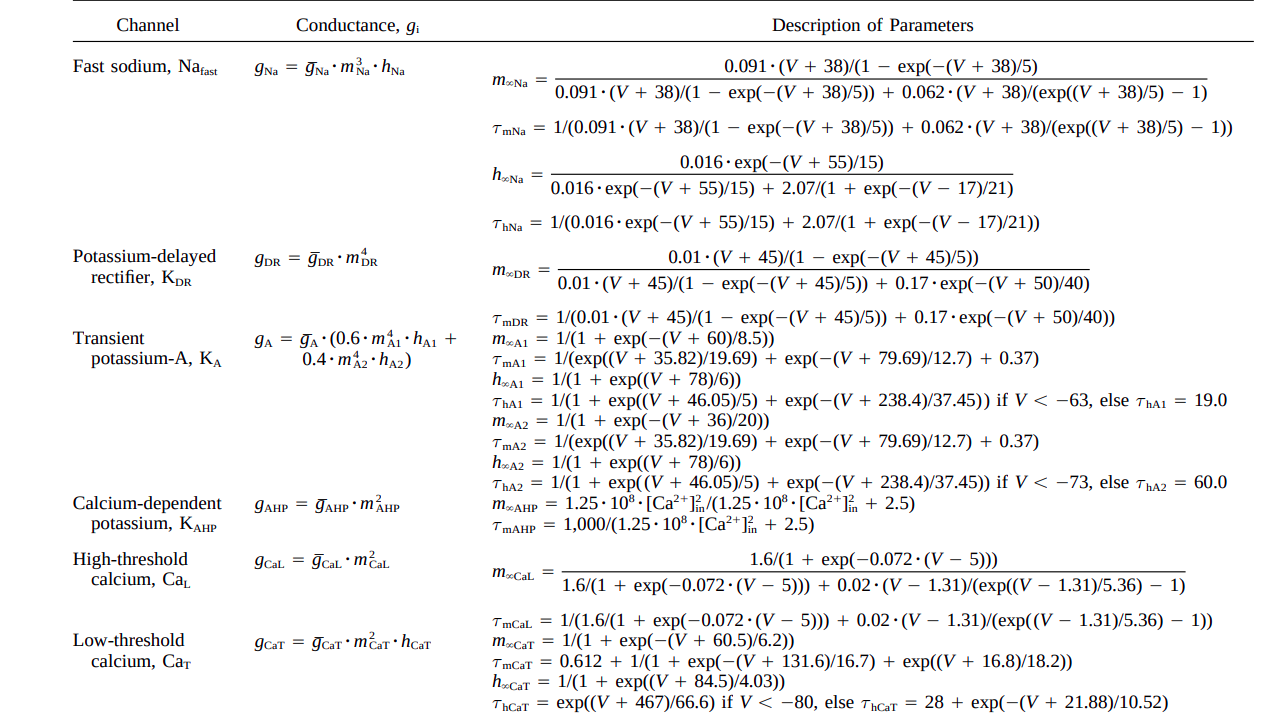

## Общий вид динамики проводимости
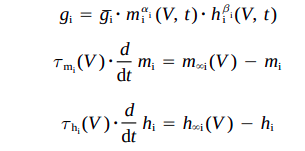

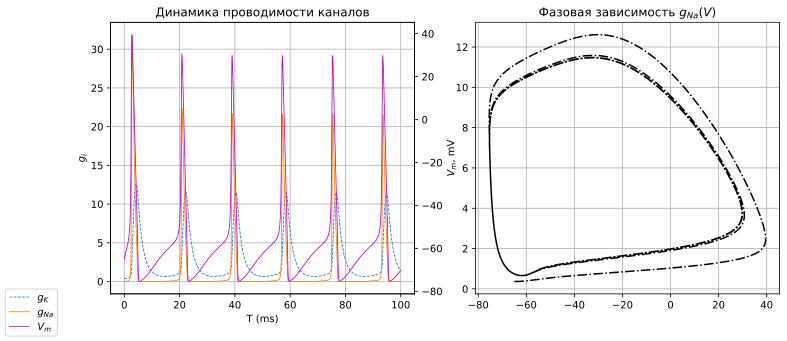

In [96]:
def solve(T):
    # computting diffirential of vector feild
    def f(y, t):
        dy = np.zeros((4,))
        Vm = y[0]
        n =  y[1]
        m =  y[2]
        h =  y[3]
        # dVm/dt
        GK = (gK / Cm) * np.power(n, 4.0)
        GNa = (gNa / Cm) * np.power(m, 3.0) * h
        GL = gL / Cm
        dy[0] = (Id(t) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl))
        # dn/dt
        dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
        # dm/dt
        dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
        # dh/dt
        dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)
        return dy
        
    # Интервалы времени наблюдения
    N = 100
    tmin = 0.0
    tmax = T
    # Значения Времени
    T = np.linspace(tmin, tmax, 5000)
    # Начальные условия задачи Коши
    Vm_0 = -65
    Y = np.array([Vm_0, n_inf(Vm_0), m_inf(Vm_0), h_inf(Vm_0)])
    #print("Вектор начальных условий:", Y)
    #Решение системы
    Vy = odeint(f, Y, T)
    fig = disp(Vy, T)
    return Vy
    
# Стимулирующий импульс(мембранный ток)
def Id(t):
    return 6.5
    
sol = solve(100)

## ТЗ
### Описание написанного кода
1. В первом блоке описаны константы и потенциальные зависимости, нормированные на потенциал покоя в -65мВ.
2. Во втором описан пример метода решения системы ХХ для произвольного времени.
3. Для каждой модели необходимо дописать необходимые зависимости от мембранного потенциала и поправить зависимости проводимостей(В коде $GK, GNa, GL$).
4. Каждая задача моделирования решается в отдельном блоке.
5. Необходимо отметить режими возбудимости данного типа нейрона.

## Fast sodium channels
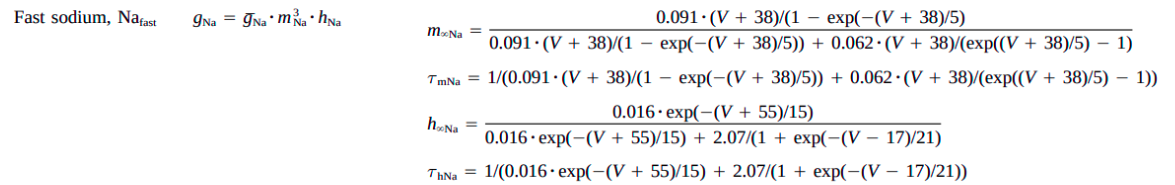

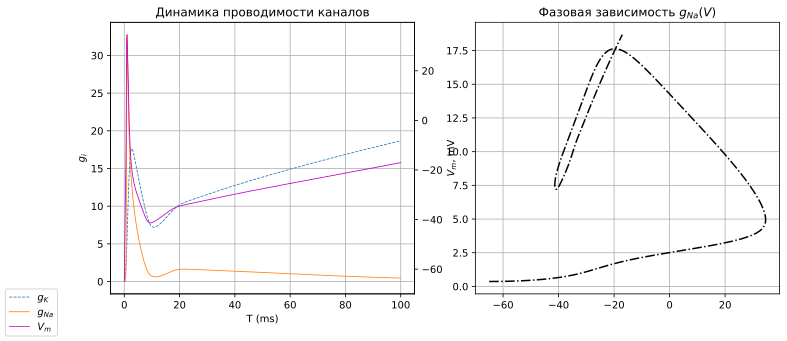

In [68]:
def m_inf_fast_sod(V):
    m_inf = 0.091*(V+38)/(1-np.exp(-(V+38)/5))/(0.091*(V+38)/(1-np.exp(-(V+38)/5))+0.062*(V+38)/(np.exp((V+38)/5)-1))
    return m_inf

def h_inf_fast_sod(V):
    h_inf = 0.016*np.exp(-(V+55)/15)/(0.016*np.exp(-(V+55)/15) + 2.07/(1+np.exp(-(V-17)/21)))
    return h_inf

def tau_m_Na(V):
    tau = 1/(0.091*(V+38)/(1-np.exp(-(V+38)/5))+0.062*(V+38)/(np.exp((V+38)/5)-1))
    return tau
def tau_h_Na(V):
    tau = 1/(0.016*np.exp(-(V+55)/15) + 2.07/(1+np.exp(-(V-17)/21)))
    return tau
            
def solve_fast_sod(T):
    # computting diffirential of vector feild
    def f(y, t):
        dy = np.zeros((4,))
        Vm = y[0]
        n =  y[1]
        m =  y[2]
        h =  y[3]
        # dVm/dt
        GK = (gK / Cm) * np.power(n, 4.0)
        GNa = (gNa / Cm) * np.power(m, 3.0) * h
        GL = gL / Cm
        dy[0] = (Id(t) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl))
        # dn/dt
        dy[1] = (n_inf(Vm) - n)
        # dm/dt
        dy[2] = (m_inf_fast_sod(Vm) - m)/tau_m_Na(Vm)
        # dh/dt
        dy[3] = (h_inf_fast_sod(Vm) - h)/tau_h_Na(Vm)
        return dy
        
    # Интервалы времени наблюдения
    N = 100
    tmin = 0.0
    tmax = T
    # Значения Времени
    T = np.linspace(tmin, tmax, 5000)
    # Начальные условия задачи Коши
    Vm_0 = -65
    Y = np.array([Vm_0, n_inf(Vm_0), m_inf(Vm_0), h_inf(Vm_0)])
    #print("Вектор начальных условий:", Y)
    #Решение системы
    Vy = odeint(f, Y, T)
    fig = disp(Vy, T)
    return Vy
    
# Стимулирующий импульс(мембранный ток)
def Id(t):
    return t*10+100
    
sol = solve_fast_sod(100)